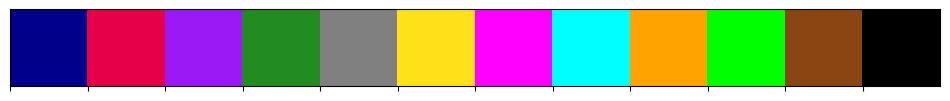

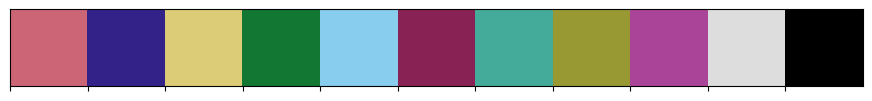

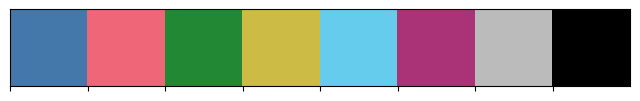

In [1]:
from glob import glob
import itertools
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_BRIGHT as PTB

from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.probe import logger
from polyphys.manage import utilizer 
from polyphys.manage.parser import TwoMonDep
from polyphys.analyze import clusters
from polyphys.analyze import measurer
import warnings
warnings.filterwarnings("ignore")
#database = '../../Datasets/'
database = '/Users/amirhsi_mini/research_data/analysis/'
dataset_save_to = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/datasets/'
figure_save_to = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/test_plots/'
sns.palplot(AC)
sns.palplot(PTM)
sns.palplot(PTB)

In [2]:
project = 'TwoMonDep'

log_details = {
    'TwoMonDep': {
        'space_pat': 'nm*am*ac*nc*',
        'hierarchy': '/am*.log',  # dir/file
        'parser': TwoMonDep,
        'lineage': 'whole',
        'geometry': 'cubic',
        'group': 'bug',
        'topology': 'atom',
        'product_idx': 1
    }
}
#log_db = "/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/"
#log_db = '/Users/amirhsi_mini/research_data/TransFociCub/logs/'
log_db = '/Users/amirhsi/research_data/'+project+'-logs/'
space_dbs = glob(log_db + log_details[project]['space_pat'] + '-logs')
space_dbs.sort()

In [3]:
thermos = []
#run_stats = []
#wall_times = []
for space_db in space_dbs:
    print(space_db)
    space = space_db.split("/")[-1]
    logs = glob(space_db + log_details[project]['hierarchy'])
    logs = organizer.sort_filenames(logs,  fmts=['.log']) # sorted
    logs = [log[0] for log in logs]
    for log in logs:
        print(log)
        log_info = log_details[project]['parser'](
            log,
            log_details[project]['lineage'],
            log_details[project]['geometry'],
            log_details[project]['group'],
            log_details[project]['topology']
        )
        lineage = log_details[project]['lineage']
        # handling product_idx in segmented logs:
        if lineage == 'segment' and log_info.segment_id>1:
            product_idx = 0
        # handling product_idx in restart logs which do not have product phase
        if  not (log.endswith('restart.log') | log.endswith('restart2ndRound.log')):
            product_idx = log_details[project]['product_idx']
        else:
            product_idx = 0
        try:
            log_data = logger.LammpsLog(log, product_idx)
        except (logger.BrokenLogError, IndexError):
            print("broken log: ", log_info.filepath.split("/")[-1])
        log_data.extract_thermo()
        #log_data.extract_run_stat()
        thermo = log_data.thermo
        #run_stat = log_data.run_stat
        #wall_time = log_data.wall_time
        for attr_name in log_info._lineage_attributes[lineage].keys():
            attr_value = getattr(log_info, attr_name)
            thermo[attr_name] = attr_value
        attr_names = ['phi_m_bulk', 'rho_m_bulk', 'phi_c_bulk', 'rho_c_bulk']
        for attr_name in attr_names:
            attr_value = getattr(log_info, attr_name)
            thermo[attr_name] = attr_value
        for lineage_name in log_info.genealogy:
            attr_value = getattr(log_info, lineage_name)
            thermo[lineage_name] = attr_value
            #run_stat[lineage_name] = attr_value
            #wall_time[lineage_name] = attr_value
        thermos.append(thermo)
        #run_stats.append(run_stat)
        #wall_times.append(wall_time)

output = "-".join(["allInOne", project, "thermo"])
thermos = pd.concat(thermos)
thermos.drop_duplicates(inplace=True)
thermos.reset_index(inplace=True, drop=True)
thermos.to_parquet(
    dataset_save_to + output + ".parquet.brotli", index=False, compression='brotli'
)
output = "-".join(["allInOne", project, "runStat"])
#run_stats = pd.concat(run_stats)
#run_stats.reset_index(inplace=True, drop=True)
#run_stats.to_csv(dataset_save_to + output + ".csv", index=False)
output = "-".join(["allInOne", project, "wallTimeStat"])
#wall_times = pd.concat(wall_times)
#wall_times.reset_index(inplace=True, drop=True)
#wall_times.to_csv(dataset_save_to + output + ".csv", index=False)

/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.0dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.1dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.2dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.3dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.4dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.5dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.

In [4]:

extensive_quants = ['e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c', 
                    'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2',
                    'fy_m1_m2', 'fz_m1_m2']

for col in extensive_quants:
    thermos[col] = thermos[col] * (thermos['ncrowd'] + 1) # 1 is for the monomer
thermos['f_m1_c'] = (thermos['fx_m1_c']**2 + thermos['fy_m1_c']**2 + thermos['fz_m1_c']**2)**0.5 
thermos['f_m2_c'] = (thermos['fx_m2_c']**2 + thermos['fy_m2_c']**2 + thermos['fz_m2_c']**2)**0.5
thermos['f_m1_m2'] = (thermos['fx_m1_m2']**2 + thermos['fy_m1_m2']**2 + thermos['fz_m1_m2']**2)**0.5

thermos['fx_dep'] = (thermos['fx_m1_c'] - thermos['fx_m2_c']) / 2
thermos['fy_dep'] = (thermos['fy_m1_c'] - thermos['fy_m2_c']) / 2
thermos['fz_dep'] = (thermos['fz_m1_c'] - thermos['fz_m2_c']) / 2
thermos['e_dep_avg'] = (thermos['e_m1_c'] + thermos['e_m2_c']) / 2
thermos['e_dep_diff'] = (thermos['e_m1_c'] - thermos['e_m2_c']) / 2

thermo_vars = ['Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'f_e_spring_1', 'f_e_spring_2',
       'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c', 'fx_m2_c',
       'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2', 'fz_m1_m2',
       'fx_dep', 'fy_dep', 'fz_dep', 'e_dep_avg', 'e_dep_diff',
       'f_m1_c', 'f_m2_c', 'f_m1_m2'
       ]
id_vars = ['nmon', 'amon', 'lcube', 'dcrowd', 'ncrowd', 'd_sur', 'dt', 'bdump',
        'adump', 'tdump', 'ensemble_id', 'phi_m_bulk', 'rho_m_bulk',
       'phi_c_bulk', 'rho_c_bulk', 'lineage_name', 'whole', 'ensemble_long',
       'ensemble', 'space']
thermos_avg = thermos.groupby(id_vars)[thermo_vars].agg(['mean', 'sem'])
thermos_avg.columns = thermos_avg.columns.to_flat_index()
new_cols = {col: '_'.join(col).strip('_') for col in thermos_avg.columns}
thermos_avg.rename(columns=new_cols, inplace=True)
thermos_avg
thermos_avg.reset_index(inplace=True)
thermos_avg_melt = pd.melt(thermos_avg, id_vars=id_vars, var_name="variable_stat", value_name='value')
# Separate the "variable_stat" into two columns: "variable" and "stat"
thermos_avg_melt[['variable', 'stat']] = thermos_avg_melt['variable_stat'].str.rsplit('_', n=1, expand=True)
# Drop the original combined column
thermos_avg_melt.drop(columns=['variable_stat'], inplace=True)
# Pivot t o get the desired structure: one column for 'mean' and one for 'var'
thermos_avg_final = thermos_avg_melt.pivot_table(
    index=id_vars + ['variable'],  # Use id_vars and variable as the index
    columns='stat',  # The 'stat' (mean/var) becomes the columns
    values='value'  # Values for mean and var
)
thermos_avg_final.reset_index(inplace=True)

In [19]:
y_labels_and_titles = {
    'e_m1_c': (r"$U_{m1,c}/ \epsilon$", "Monomer A: Crowders"),
    'f_m1_c': (r"$F_{m1,c}a_c / \epsilon$", "Monomer A: Crowders"),
    'fx_m1_c': (r"$f_{m1,c,x}a_c / \epsilon$", "Monomer A: Crowders"),
    'fy_m1_c': (r"$f_{m1,c,y}a_c / \epsilon$", "Monomer A: Crowders"),
    'fz_m1_c': (r"$f_{m1,c,z}a_c / \epsilon$", "Monomer A: Crowders"),
    'e_m2_c': (r"$U_{m2,c}/ \epsilon$", "Monomer B: Crowders"),
    'f_m2_c': (r"$F_{m2,c}a_c / \epsilon$", "Monomer B: Crowders"),
    'fx_m2_c': (r"$f_{m2,c,x}a_c / \epsilon$", "Monomer B: Crowders"),
    'fy_m2_c': (r"$f_{m2,c,y}a_c / \epsilon$", "Monomer B: Crowders"),
    'fz_m2_c': (r"$f_{m2,c,z}a_c / \epsilon$", "Monomer B: Crowders"),
    'e_m1_m2': (r"$U_{m1,m2}/ \epsilon$", "Monomer A: Monomer B"),
    'f_m1_m2': (r"$F_{m1,m2}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fx_m1_m2': (r"$f_{m1,m2,x}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fy_m1_m2': (r"$f_{m1,m2,y}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fz_m1_m2': (r"$f_{m1,m2,z}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fx_dep': (r"$F_{\text{dep},x}a_c / \epsilon$", r"$F_{\text{dep},x}=\frac{1}{2}\langle \sum_c (f_{Ac,x}-f_{Bc,x}) \rangle$"),
    'fy_dep': (r"$F_{\text{dep},y}a_c / \epsilon$", r"$F_{\text{dep},y}=\frac{1}{2}\langle \sum_c (f_{Ac,y}-f_{Bc,y} \rangle$"),
    'fz_dep': (r"$F_{\text{dep},z}a_c / \epsilon$", r"$F_{\text{dep},z}=\frac{1}{2}\langle \sum_c (f_{Ac,z}-f_{Bc,z}) \rangle$"),
    'e_dep_avg': (r"$U_{\text{dep, avg}}/ \epsilon$", "Average Depletion Energy"),
    'e_dep_diff': (r"$U_{\text{dep, diff}}/ \epsilon$", "Differential Depletion Energy")
}

In [14]:
for thermo_var in thermo_vars:
    grid = sns.relplot(
        data=thermos,
        x='Step',
        y=thermo_var,
        col='d_sur',
        col_wrap=7,
        kind='line', 
    )
    grid.tight_layout()
    grid.figure.savefig(figure_save_to+f"time_series-d_sur_as_col-{thermo_var}.pdf")
    plt.close()

In [8]:
# Property to plot (mean or sem)
y_property = 'mean'
# Columns representing energy (e) and force (f) components in the system
selected_columns = [
    'e_m1_c', 'e_m2_c', #'e_m1_m2', 
    #'f_m1_c', 'f_m2_c', 'f_m1_m2', # Total forces
    'fx_m1_c', 'fy_m1_c', 'fz_m1_c',  # Monomer A to crowders
    'fx_m2_c', 'fy_m2_c', 'fz_m2_c',  # Monomer B to crowders
    #'fx_m1_m2', 'fy_m1_m2', 'fz_m1_m2',  # Monomer A to Monomer B
    'fx_dep', 'fy_dep', 'fz_dep',  # Depletion forces
    #'e_dep_avg', 'e_dep_diff'  # Average and differential depletion energy
]
# Filter the data for the selected variables (forces and energies)
plot_data = thermos_avg_final.loc[
    thermos_avg_final['variable'].isin(selected_columns),
    ['d_sur', 'mean', 'sem', 'variable']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    col_order=selected_columns,
    col_wrap=3,
    kind='line',
    marker='s',
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")

# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{figure_save_to}equilibrium_var_vs_d_sur-{y_property}.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()

In [42]:
# Property to plot (mean or sem)
y_property = 'mean'

# Columns representing energy (e) and force (f) components in the system
selected_columns = [
    #'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c',  # Monomer A to crowders
    #'e_m2_c', 'fx_m2_c', 'fy_m2_c', 'fz_m2_c',  # Monomer B to crowders
    'fx_dep', 'fy_dep', 'fz_dep',  # Depletion forces
    #'e_dep_avg', 'e_dep_diff'  # Average and differential depletion energy
]


# Filter the data for the selected variables (forces and energies)
plot_data = thermos_avg_final.loc[
    thermos_avg_final['variable'].isin(selected_columns),
    ['d_sur', 'mean', 'sem', 'variable']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    col_order=selected_columns,
    col_wrap=3,
    kind='line',
    marker='s',
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")
# Add legend below the entire figure
# Adjust space below the figure to fit the legend
grid.figure.subplots_adjust(bottom=0.5, left=0)
# Add legend below the entire figure
legend_text = "A: Monomer 1 | B: Monomer 2 | c: Crowders"
grid.figure.text(0.52, 0, legend_text, ha='center', fontsize=12)
# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{figure_save_to}equilibrium_var_vs_d_sur-{y_property}.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()

In [ ]:
grid.axes_dict